# Лабораторная работа №1

**Требования:**
* Python >= 3.X

Лабораторную работу необходимо выполнять в данном шаблоне. Результатом работы будет являться файл (с измененным именем), который необходимо выложить в Moodle.

**Важно!!!** Имя файлу задавайте по следующему шаблону **lab_1_Группа_ФамилияИО.ipynb**. Например: если Вас зовут Иванов Иван Иванович, и Вы обучаетесь в группе 6207_010302D, то имя файла будет выглядеть так **lab_1_6407_010302D_ИвановИИ.ipynb**.

In [51]:
# Код загрузки данных
# Если хотите добавить какие-либо библиотеки
# добавляйте их ИМЕННО ЗДЕСЬ
import nltk
import inflect
import re
nltk.download('gutenberg', quiet=True)
nltk.download('punkt', quiet=True)

# Наименования книг
books = []
# Содержимое книг
raw_texts = []

for fileid in nltk.corpus.gutenberg.fileids():
    books.append(fileid)
    raw_texts.append(nltk.corpus.gutenberg.raw(fileid))

#### Шаг №1
Предобработайте тексты, которые содержатся в списке `raw_texts`, но сначала внимательно изучите их структуру. Сохраните полученные данные в списке `books_tokens` (в разрезе книг, как и было с сырыми текстами).

Порядок обработки текста:
* Замените все числа, которые представлены цифрами, их текстовым представлением (т.е. прописью). Пример: 1 = one, 23 = twenty three, 1042 = one thousand forty two, и т.п. См. библиотеку **inflect**.
* Приведите текст к нижнему регистру
* Произведите токинезацию, в качестве токенов выступают слова.

Подсказка: рекомендуется отлаживать алгоритмы на паре книг, рассчеты на всем корпусе идут продолжительное время.

In [52]:
# вставьте код здесь
p = inflect.engine()

text = raw_texts[0]

# Функция для замены обычных и порядковых чисел на их текстовые эквиваленты
def replace_numbers_and_ordinals_with_words(match):
    full_match = match.group(0)
    # Извлекаем базовое число из порядкового числа, если оно есть
    number_only = re.sub(r'[^0-9]', '', full_match)
    if full_match[-2:] in ["st", "nd", "rd", "th"]: # Проверяем на порядковость
        # Преобразуем порядковое число в текст, используя извлеченное базовое число
        word = p.ordinal(p.number_to_words(number_only))
    else:
        # Преобразуем число в текстовое представление
        word = p.number_to_words(number_only)
    return word

# Регулярное выражение теперь также ищет порядковые числа
text_with_words = re.sub(r'\d+(st|nd|rd|th)|\d+', replace_numbers_and_ordinals_with_words, text)

# print(text)
# print(text_with_words)
print(nltk.word_tokenize(text_with_words.lower())[:25])

['[', 'emma', 'by', 'jane', 'austen', 'one', 'thousand', ',', 'eight', 'hundred', 'and', 'sixteen', ']', 'volume', 'i', 'chapter', 'i', 'emma', 'woodhouse', ',', 'handsome', ',', 'clever', ',', 'and']


#### Шаг №2

* Вычислите словари для каждой книги (переменная `books_vocabularies`).
* Вычислите словарь для всего корпуса (переменная `books_vocabulary`).
* Рассчитайте частоту употребления токенов в корпусе (переменная `freq_tokens`), и постройте график зависимости частоты употребления токена от токена (для 30-ти самых популярных).

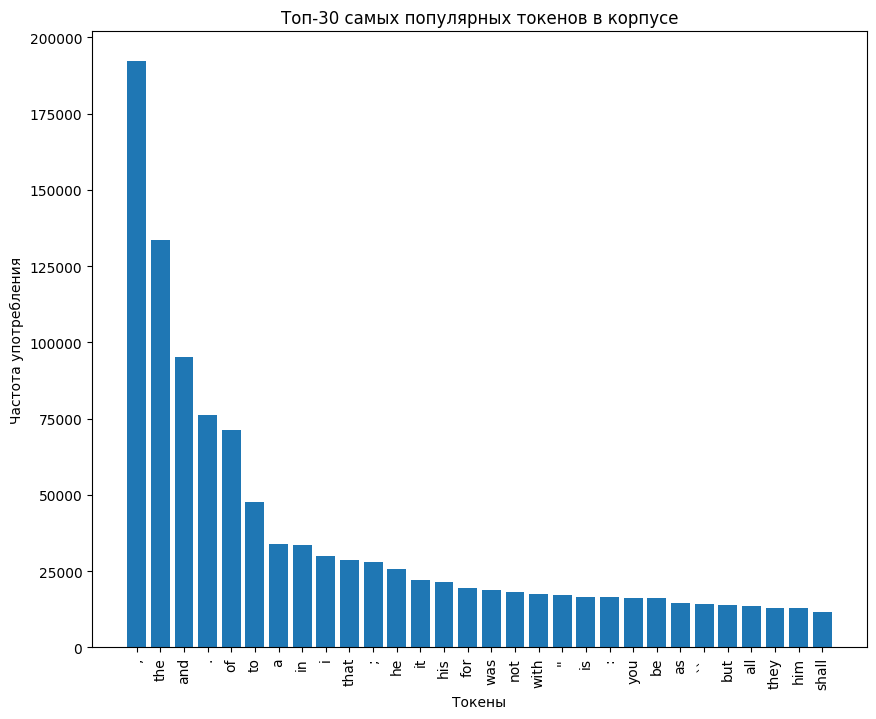

In [53]:
# вставьте код здесь
from collections import Counter
import matplotlib.pyplot as plt

# Создаем словари для каждой книги
books_vocabularies = [set(nltk.word_tokenize(text.lower())) for text in raw_texts]

# Создаем словарь для всего корпуса, объединяя словари каждой книги
books_vocabulary = set().union(*books_vocabularies)

# Токенизируем весь корпус для подсчета частоты употребления токенов
all_tokens = nltk.word_tokenize(' '.join(raw_texts).lower())

# Рассчитываем частоту употребления токенов
freq_tokens = Counter(all_tokens)

# Сортируем токены по частоте употребления и выбираем 30 самых популярных
most_common_tokens = freq_tokens.most_common(30)

# Подготавливаем данные для графика
tokens = [token for token, freq in most_common_tokens]
frequencies = [freq for token, freq in most_common_tokens]

# Построение графика
plt.figure(figsize=(10, 8))
plt.bar(tokens, frequencies)
plt.xlabel('Токены')
plt.ylabel('Частота употребления')
plt.title('Топ-30 самых популярных токенов в корпусе')
plt.xticks(rotation=90)
plt.show()

#### Шаг №3
* Сгенерируйте список триграмм (переменная `trigrams`) по всему корпусу и рассчитайте частоту их употребления (переменная `freq_trigrams`).
* Реализуйте наивный генератор текста (30 токенов). 
    1. Для затравки берется два стартовых токена, которые становятся текущими. Первый токен выводится на экран.
    2. Второй токен из активной пары токенов выводится на экран. Если мы сгененрировали нужное количество текста, то останавливаем алгоритм.
    3. По текущей паре токенов (первые в триграмме) определяется наиболее употребительная траграмма, которая помечается как использованная. Использованные триграммы на последующих шагах в рассмотрении не участвуют. Второй и третий токены данной триграммы становятся текущими. Переходим к п. 2.

In [55]:
# вставьте код здесь
from nltk import trigrams as nltk_trigrams
from collections import defaultdict

# Генерируем список триграмм по всему корпусу
all_trigrams = list(nltk_trigrams(all_tokens))

# Рассчитываем частоту употребления триграмм
freq_trigrams = Counter(all_trigrams)

# Наивный генератор текста
def generate_text(start_tokens, num_tokens=30):
    if len(start_tokens) != 2:
        raise ValueError("Start tokens should be a list of two tokens.")
    
    # Инициализация текста стартовыми токенами
    text = [start_tokens[0], start_tokens[1]]
    current_tokens = (start_tokens[0], start_tokens[1])
    
    # Список для отслеживания использованных триграмм
    used_trigrams = set()
    
    for _ in range(num_tokens - 2): # Вычитаем два, потому что два токена уже добавлены
        possible_trigrams = [trigram for trigram in freq_trigrams if trigram[:2] == current_tokens and trigram not in used_trigrams]
        
        if not possible_trigrams:
            break # Останавливаем, если нет подходящих триграмм
        
        # Выбор наиболее частой триграммы из доступных
        next_trigram = max(possible_trigrams, key=lambda trigram: freq_trigrams[trigram])
        
        # Добавляем новый токен в текст и обновляем текущие токены
        next_token = next_trigram[2]
        text.append(next_token)
        current_tokens = (current_tokens[1], next_token)
        
        # Помечаем триграмму как использованную
        used_trigrams.add(next_trigram)
    
    return ' '.join(text)

# Генерация текста с затравкой из двух первых токенов корпуса
start_tokens = [all_tokens[0], all_tokens[1]]
generated_text = generate_text(start_tokens)

print(generated_text)

[ emma by jane austen 1816 ] volume i chapter i emma woodhouse , i will not be afraid of the lord , and the lord . and he said
